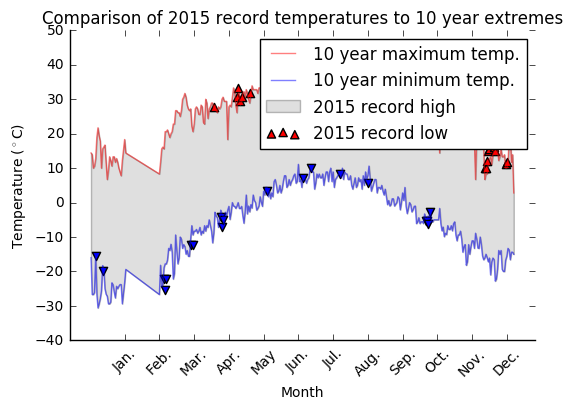

In [1]:
"""
Applied Plotting, Charting & Data Representation in Python
Assignmnet 2
Plotting Weather Patterns
"""
import os
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook 

def read_data(file_csv):
    """Helper for reading data into data frame.
    Returns df to be used for plotting weather patterns.
    Read raw data, no transformations on this stage.S
    """
    # Set path to file, with os library - so it will work under diferent filesystems
    pth = os.path.normpath('./data/C2A2_data/BinnedCsvs_d400')
    pth = os.path.join(pth, file_csv)
    data_frame = pd.read_csv(pth)
    # DONE convert Y scale to full degrees
    # convert to full degrees
    data_frame['Data_Value'] = data_frame['Data_Value'] / float(10)
    return data_frame

def get_date_index(data_frame):
    """Helper to get DatetimeIndex object for a data_frame.
    Required for filtering and sorging dates, stored as str in
    data frame.
    DatatimeIndex allows to extract parts of date.
    """
    return pd.DatetimeIndex(data_frame['Date'])

def drop_leap_days(data_frame):
    """Helper function to drop leap dates in df column df['Date'].
    Pandas DataFrame passed as argument."""
    # Create DatetimeIndex object for filtering dates in df
    dt_idx = get_date_index(data_frame)

    # Remove all 29th Feb in data frame
    data_frame = data_frame.loc[(dt_idx.month != 2) & (dt_idx.day != 29)]
    return data_frame

def split_by_years(data_frame):
    """Helper function for splitting data into subsets. Returns touple of DataFrames.
    First DataFrame in output is for 2005-2014, second is for 2015 dates.
    """
    dt_idx = get_date_index(data_frame)
    # Data to be used for plot base
    base_data = data_frame.loc[(dt_idx.year > 2005) & (dt_idx.year < 2015)]

    # Data to be used for overlaying
    overlay_data = data_frame.loc[dt_idx.year == 2015]
    return (base_data, overlay_data)

def group_by_date(data_frame):
    """ Helper function - group observations in df DataFrame by day of year and [Element] column.
    Calculate mean of Data_Value for grouped data.
    Function is discarding year value. For the purpose of excercise, df needs to be split
    into 2005-2014 and 2015 subsets.
    """

    # Extract TMAX and TMIN indexes
    idx_tmax = data_frame['Element'] == 'TMAX'
    idx_tmin = data_frame['Element'] == 'TMIN'

    # Calculate ten year daily max temp.
    tmax_df = data_frame[idx_tmax]
    tnax_di = get_date_index(tmax_df)
    tmax_grouped = tmax_df.groupby(tnax_di.dayofyear).max()
    tmax_grouped.index.name = 'day_of_year'

    # Calculate ten year daily min temp.
    tmin_df = data_frame[idx_tmin]
    tmin_di = get_date_index(tmin_df)
    tmin_grouped = tmin_df.groupby(tmin_di.dayofyear).min()
    tmin_grouped.index.name = 'day_of_year'

    #Join min and max temperatures
    temp_data = {'TMAX': tmax_grouped['Data_Value'], 'TMIN' : tmin_grouped['Data_Value']}
    grouped_data = pd.DataFrame(index=tmax_grouped.index, data=temp_data)

    return grouped_data

def prepare_data(data_frame):
    """Prepare data for plotting.
    Takes data frame read from csv - before any transformations.
    Removes leap days.
    Splits into subframes.
    Groups by day_of_year and [Element]
    Returns touple of data frames, for constructiong plot.
    """
    df_no_leap = drop_leap_days(data_frame)
    base_raw, overlay_raw = split_by_years(df_no_leap)
    base_grouped = group_by_date(base_raw)
    overlay_grouped = group_by_date(overlay_raw)
    merged_data = pd.merge(base_grouped, overlay_grouped,
                           right_index=True, left_index=True, how='left',
                           suffixes=('_base', '_over'))
    merged_data = remove_non_record(merged_data)
    return merged_data

def remove_non_record(merged_data):
    """Helper function for removing 2015 observations that are not 'record' values.
    Takes merged temeperature data frame as argument.
    Remove TMAX_over that are above TMAX_base.
    Remove TMIN_over that are belov TMIN_base.
    """
    # Identify record hi and record low temeperatures in 2015
    record_hi = merged_data['TMAX_over'] > merged_data['TMAX_base']
    record_lo = merged_data['TMIN_over'] < merged_data['TMIN_base']

    # Set non-record temeperatures to None - exclude from scatterplot
    merged_data.loc[~record_hi, 'TMAX_over'] = None
    merged_data.loc[~record_lo, 'TMIN_over'] = None
    return merged_data

def plot_weather(data_frame):
    """Plot data as required in the assignment.
    Takes pandas data frame as argument"""
    merged_data = prepare_data(data_frame)

    # record temperatures in 2015
    tmax_over = merged_data['TMAX_over']
    tmin_over = merged_data['TMIN_over']

    # min/max temperatures over 10 years
    tmax_base = merged_data['TMAX_base']
    tmin_base = merged_data['TMIN_base']

    # DONE x label to be more informative
    tick_values = [30, 60, 90, 120,
                   150, 180, 210, 240,
                  270, 300, 330, 360]
    tick_labels = ['Jan.', 'Feb.', 'Mar.', 'Apr.',
                   'May', 'Jun.', 'Jul.', 'Aug.',
                   'Sep.', 'Oct.', 'Nov.', 'Dec.']

    plt.plot(tmax_base, 'r-', alpha=0.5)
    plt.plot(tmin_base, 'b-', alpha=0.5)
    plt.xticks(tick_values, tick_labels, rotation=45)

    plt.title('Comparison of 2015 record temperatures to 10 year extremes')
    plt.xlabel('Month')
    plt.ylabel('Temperature ($^\circ$C)')

    # TODO fix fill between - not new data series
    ax = plt.gca()
    ax.fill_between(tmax_base.index,
        tmax_base, tmin_base,
        facecolor='gray',
        alpha=0.25)

    # DONE colors of min and max lines (blue and red?)
    plt.scatter(x=tmax_over.index, y=tmax_over.values, c='red', marker='^', s=35)
    plt.scatter(x=tmin_over.index, y=tmin_over.values, c='blue', marker='v', s=35)

    plt.legend(['10 year maximum temp.', '10 year minimum temp.', '2015 record high', '2015 record low'])
    
    # remove spines from plot
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()


data_frame = read_data('fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
plot_weather(data_frame)
